In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from utils.utils import *
from utils.constants import *

In [5]:
# Import data


y_train = pd.read_csv(get_absolute_path('y_train.csv', 'data'))
y_test  = pd.read_csv(get_absolute_path('y_test.csv', 'data'))


stack_train = pd.read_csv(get_absolute_path('stacked_X_tr.csv', 'data'))
stack_test  = pd.read_csv(get_absolute_path('stacked_X_te.csv', 'data'))

stack_train = stack_train.astype(column_data_extended_types)
stack_test = stack_test.astype(column_data_extended_types)

# Select numeric and categorical columns
numeric_columns = stack_train.select_dtypes(include=['float64']).columns
categorical_columns = [#'Date', 
                       'Location_ID',
                    #    'Year',
                       'Month',
                       'Week',
                       'Weekday',
                       'Season'
                       ]  # Add any categorical columns here

# Create preprocessing transformers
numeric_transformer = StandardScaler()  # we can use other scalers as well
categorical_transformer = OneHotEncoder(drop=None)  # Use one-hot encoding for categorical columns

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Fit the preprocessor on training data and transform both train and test data
X_train_preprocessed = preprocessor.fit_transform(stack_train)
X_test_preprocessed  = preprocessor.transform(stack_test)


# Get the column names after one-hot encoding
categorical_encoded_columns = preprocessor.named_transformers_['cat']\
                                    .get_feature_names_out(input_features=categorical_columns)

# Convert X_train_preprocessed and X_test_preprocessed to DataFrames

X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed.toarray(), columns=np.concatenate([numeric_columns, categorical_encoded_columns]))
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed.toarray(), columns=np.concatenate([numeric_columns, categorical_encoded_columns]))


In [30]:
param_grid = {
    "alpha":[0.01, 0.001, 0.0001, 0.00001, 0.000001],
    "l1_ratio": [0, 0.1, 0.3, 0.5, 0.8, 1]
}

# Create a MLP model
reg_lin = ElasticNet(random_state=0, l1_ratio=1, alpha = 0.00001).fit(X_train_preprocessed_df,y_train)


# Pemlporm hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(reg_lin, param_grid, cv=10, scoring="neg_root_mean_squared_error", verbose=1)
grid_search.fit(X_train_preprocessed, y_train)

KeyboardInterrupt: 

In [ ]:
# Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

In [ ]:
best_params

{'alpha': 1e-05, 'l1_ratio': 1}

In [ ]:
best_model

ElasticNet(alpha=1e-05, l1_ratio=1, random_state=0)

In [ ]:
type(best_model)

sklearn.linear_model._coordinate_descent.ElasticNet

In [ ]:
best_score

-0.011582895949056912

In [ ]:
y_pred = best_model.predict(X_test_preprocessed_df)
rmse = mean_squared_error(y_test, y_pred, squared=False)

/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


In [ ]:
rmse

0.011913692392905944

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e-02, tolerance: 1.345e-03
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


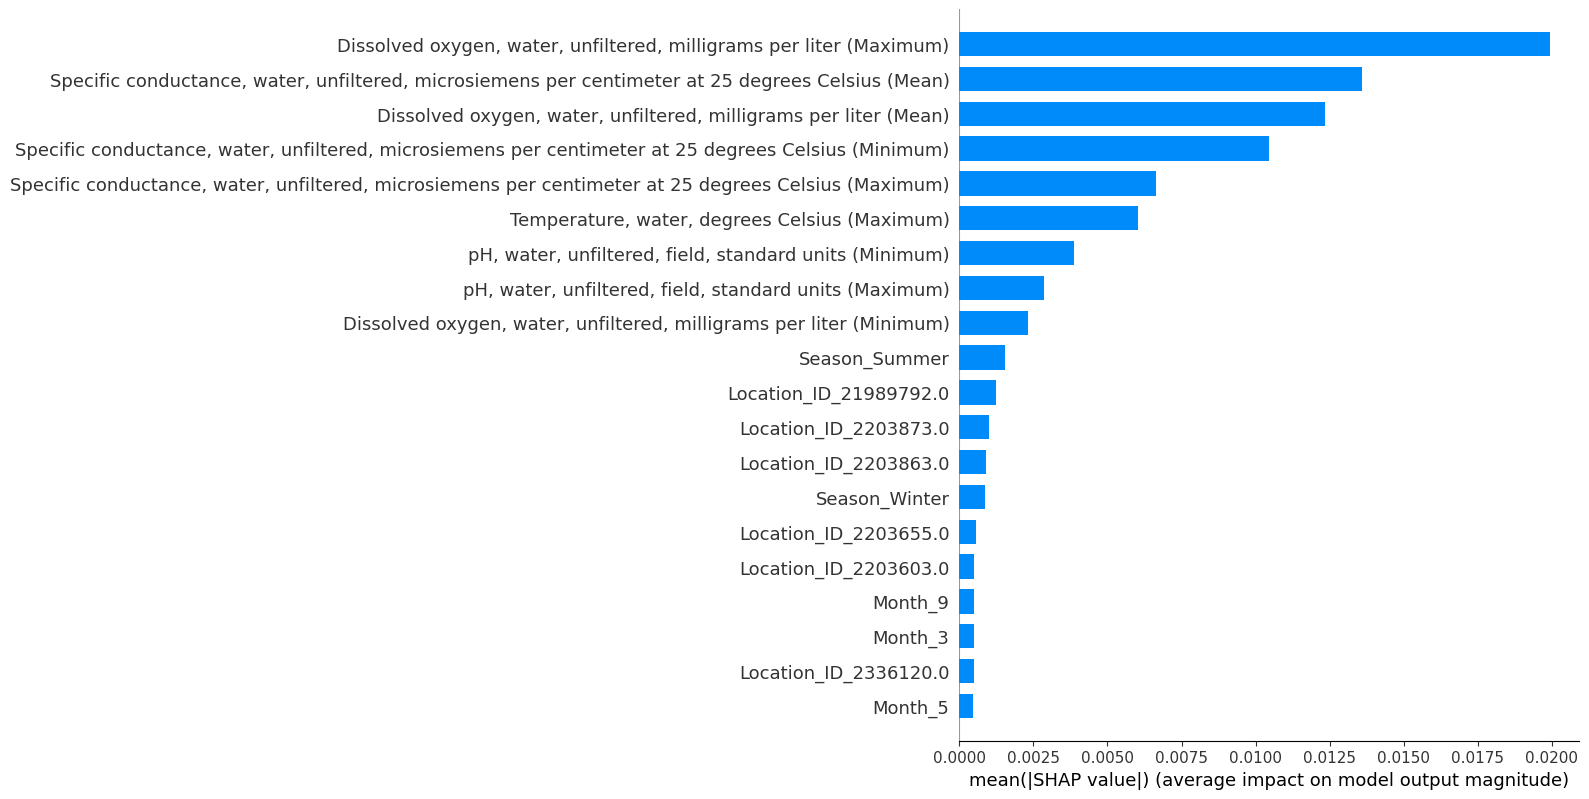

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


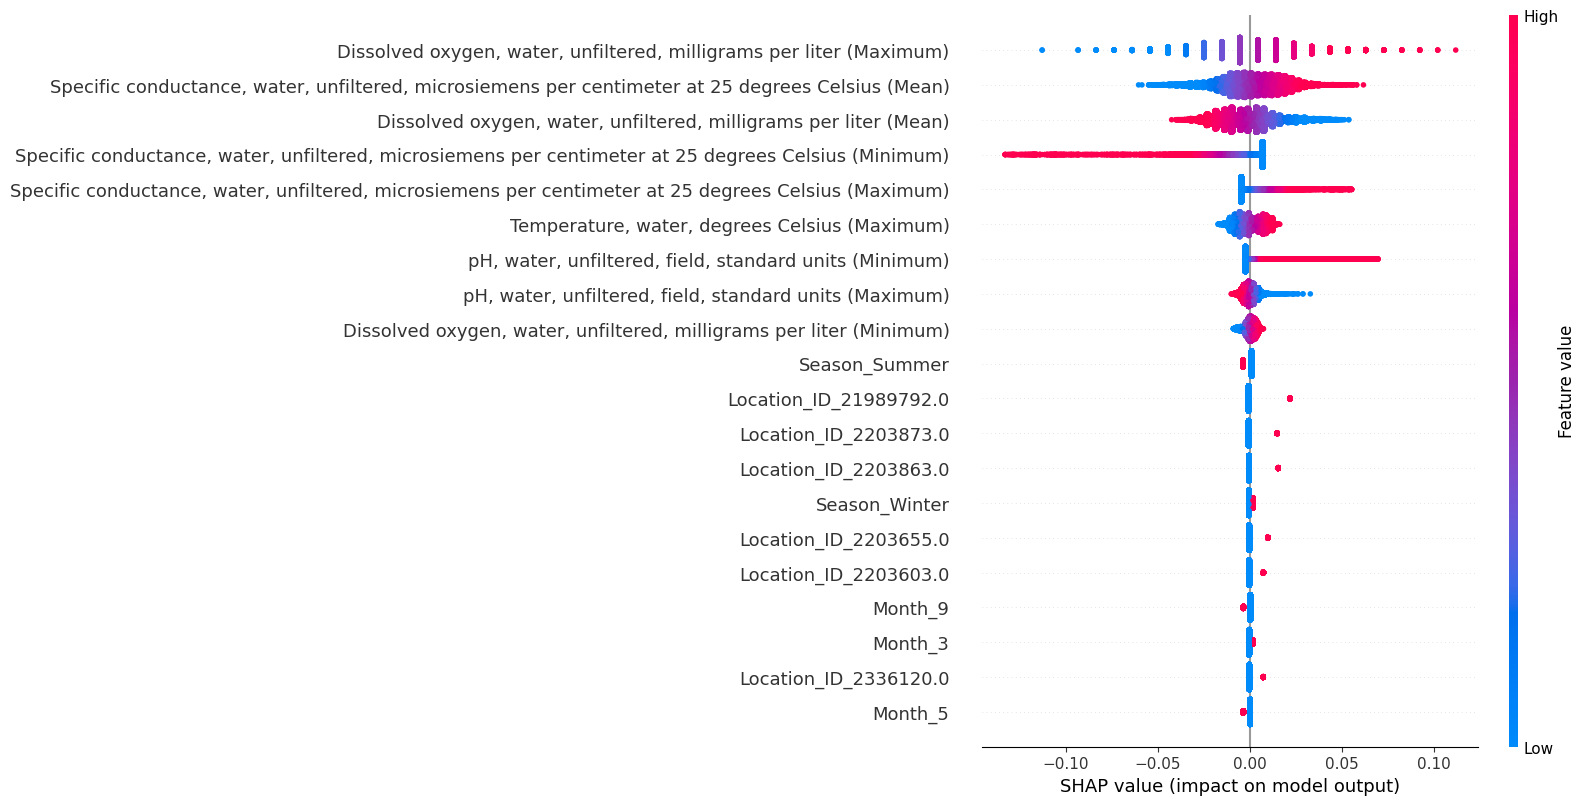

In [ ]:
### Shap

import shap
np.bool = np.bool_
np.int = np.int_

best_model.fit(X_train_preprocessed_df,y_train)

explainer = shap.LinearExplainer(best_model, X_train_preprocessed_df)

shap_values = explainer.shap_values(X_train_preprocessed_df)

shap.summary_plot(shap_values, X_train_preprocessed_df, plot_type="bar")

shap.summary_plot(shap_values, X_train_preprocessed_df)

In [6]:
from utils.metrics import *
from utils.constants import *

In [7]:
best_lin_file = get_absolute_path(
    file_name = 'best_lin_model.joblib'
    , rel_path = 'results'
)

In [8]:
X_train=X_train_preprocessed_df
y_train=y_train
X_test=X_test_preprocessed_df
y_test=y_test
param_grid={
    "alpha":[0.01, 0.001, 0.0001, 0.00001, 0.000001],
    "l1_ratio": [0, 0.1, 0.3, 0.5, 0.8, 1]
}
model=ElasticNet(random_state=0, l1_ratio=1, alpha = 0.00001).fit(X_train_preprocessed_df,y_train)
scoring="neg_root_mean_squared_error"
eval_func=compute_metrics
file_path=best_lin_file
cv=5

/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e-02, tolerance: 1.345e-03
  model = cd_fast.enet_coordinate_descent(


In [9]:
# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

# Making predictions on the validation data using the best model
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Int

/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.268e-01, tolerance: 1.032e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.714e-01, tolerance: 1.101e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted

In [11]:
# Calculate evaluation metrics
_df = pd.DataFrame(
    {
        'forecast': y_pred,
        'actual': y_test['measurement']
    }
)
eval_metrics = eval_func(_df, EVAL_METRIC_LIST)

In [12]:
eval_metrics

{'rmse': 0.011913692392905538,
 'mape': 0.010792014828810443,
 'wmape': 0.010957849504397257,
 'wbias': 0.0013146181043680206,
 'wuforec': 0.006136233804382638,
 'woforec': 0.004821615700014619}

In [13]:
type(best_model)

sklearn.linear_model._coordinate_descent.ElasticNet

In [14]:
if isinstance(best_model, (MLPRegressor, ElasticNet)): # type(best_model) == MLPRegressor
    feature_importance_dict = {}

In [16]:
# Save the results
best_model_info = {
    'best_params': best_params,
    'best_score': best_score,
    'feature_importance': feature_importance_dict,
    'y_pred': y_pred,
    'eval_metrics': eval_metrics
}

In [17]:
best_model_info

{'best_params': {'alpha': 1e-05, 'l1_ratio': 1},
 'best_score': -0.011918253086973673,
 'feature_importance': {},
 'y_pred': array([0.66390174, 0.70198615, 0.69518118, ..., 0.68769368, 0.66037844,
        0.65492018]),
 'eval_metrics': {'rmse': 0.011913692392905538,
  'mape': 0.010792014828810443,
  'wmape': 0.010957849504397257,
  'wbias': 0.0013146181043680206,
  'wuforec': 0.006136233804382638,
  'woforec': 0.004821615700014619}}

In [54]:
import pandas as pd
import os
import sys
import ast
from typing import Union
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from utils.utils     import *
from utils.constants import *
from utils.metrics   import *

# Scripts:


def hyperparameter_tuning(
        X_train: pd.DataFrame,
        y_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_test: pd.DataFrame,
        param_grid: dict,
        model: Union[xgb.sklearn.XGBRegressor, RandomForestRegressor
                     , lgb.LGBMRegressor, MLPRegressor
                     ],
        scoring,
        eval_func,
        file_path: str,
        cv: int
) -> dict:
    """
    Perform hyperparameter tuning, prediction, and evaluation for a given model.

    Parameters:
    X_train (pd.DataFrame): Training features.
    y_train (pd.DataFrame): Training target values.
    X_test (pd.DataFrame): Testing features.
    y_test (pd.DataFrame): Testing target values.
    param_grid (dict): Grid of hyperparameters for tuning.
    model (Union[xgb.sklearn.XGBRegressor, RandomForestRegressor]): Initialized model.
    scoring (function): Scoring function for hyperparameter tuning.
    eval_func (function): Evaluation function for model performance.
    file_path (str): File path for saving the best model and results.
    cv (int): Number of cross-validation folds.

    Returns:
    dict: Dictionary containing best model information and evaluation metrics.
    
    Example:
    X_train = X_train_preprocessed_df
    y_train = y_train
    X_test  = X_test_preprocessed
    y_test = y_test
    model = xgb.XGBRegressor(objective='reg:squarederror') # RandomForestRegressor()
    scoring = make_scorer(lambda y_true, y_pred: -mean_squared_error(y_true, y_pred, squared=False))
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [None, 3, 5, 10, 20],
        'min_samples_split': [1, 2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    eval_func = compute_metrics
    
    """

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=6, verbose=1)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters and best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_

    # Making predictions on the validation data using the best model
    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    _df = pd.DataFrame(
        {
            'forecast': y_pred,
            'actual': y_test['measurement']
        }
    )
    eval_metrics = eval_func(_df, EVAL_METRIC_LIST)

    # Get feature importance scores for tree based models

    if isinstance(best_model, MLPRegressor): # type(best_model) == MLPRegressor
        feature_importance_dict = {}
    else:
        # Get feature importance scores
        feature_importance = best_model.feature_importances_
        feature_names = X_train.columns
        feature_importance_dict = dict(zip(feature_names, feature_importance))

    # Save the results
    best_model_info = {
        'best_params': best_params,
        'best_score': best_score,
        'feature_importance': feature_importance_dict,
        'eval_metrics': eval_metrics
    }
    
    # Save the best model and results
    save_model(file_name=file_path, model=best_model, model_info=best_model_info)

    return best_model_info




In [56]:
EVAL_METRIC_LIST = ['rmse','mape','wmape','wbias','wuforec','woforec']

In [57]:
best_mlp_file = get_absolute_path(
    file_name = 'best_mlp_model.joblib'
    , rel_path = 'results'
)

mlp_result = hyperparameter_tuning(
        X_train=X_train_preprocessed,
        y_train=y_train,
        X_test=X_test_preprocessed,
        y_test=y_test,
        param_grid= {
            'hidden_layer_sizes': list(zip([1000], [300])),
            #'max_iter': [50, 100],
            #'activation': ['tanh', 'relu'],
            #'solver': ['sgd', 'adam'],
            #'alpha': [0.0001, 0.05],
            #'learning_rate': ['constant','adaptive'],
        },
        model=MLPRegressor(random_state=1, hidden_layer_sizes = (20, 20)),
        scoring="neg_root_mean_squared_error",
        eval_func=compute_metrics,
        file_path=best_mlp_file,
        cv=5
) 

print("Success of MLP!")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/si

Success of MLP!
